## Libraries

In [1]:
# Importing data from the r/politics
from psaw import PushshiftAPI
from datetime import datetime, timezone, date
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm, tqdm_pandas
from nltk.draw.dispersion import dispersion_plot
from collections import Counter
import datetime as dt
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import shifterator as sft
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from ast import literal_eval
tqdm.pandas()

C:\Users\JaQtae\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
def setup_mpl():
    #mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '14'
    mpl.rcParams['lines.linewidth'] = 3
setup_mpl()

# WordCloud
Loading in the data 

In [3]:
local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\FINAL_COMMENTS.csv"
com_data = pd.read_csv(local_storage, index_col=0, parse_dates=[0], converters={'tokens': literal_eval})
com_data.index = com_data.index.rename('dates')
# The collected comments data set still contained some data from 2020-09-30. This is removed. 

# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)
com_data.head()

,id,link_id,score,author,parent_id,body,parent_author,tokens,politician,children_comments,mentions_Trump,mentions_Biden,compound_sentiment_score,date,day
dates,,,,,,,,,,,,,,,
2020-11-02 23:26:26,gay6kwb,t3_jmybs3,1,J_Class_Ford,t1_gay5x5w,Division is his weapon,cyanydeez,"[division, weapon]",Trump,[],NaN,NaN,-0.2960,2020-11-02 23:26:26,2020-11-02
2020-11-02 23:20:27,gay5x5w,t3_jmybs3,1,cyanydeez,t1_gay5pjk,"dunno, everything trump does seems to generate...",J_Class_Ford,"[dunno, everything, trump, seems, generate, re...",Trump,['gay6kwb'],True,NaN,0.0000,2020-11-02 23:20:27,2020-11-02
2020-11-02 23:18:33,gay5pjk,t3_jmybs3,1,J_Class_Ford,t1_gay5doq,Not sure it generates many more votes. I work ...,cyanydeez,"[sure, generates, many, votes, work, assumptio...",Trump,['gay5x5w'],True,NaN,-0.0160,2020-11-02 23:18:33,2020-11-02
2020-11-02 23:15:36,gay5doq,t3_jmybs3,1,cyanydeez,t1_gay3si8,"yeah, but for every vote this generates, would...",J_Class_Ford,"[yeah, every, vote, generates, would, think, c...",Trump,['gay5pjk'],NaN,NaN,0.5450,2020-11-02 23:15:36,2020-11-02
2020-11-02 23:04:18,gay43vt,t3_jmybs3,1,Tesides,t3_jmybs3,I really do believe this idiot is trying to lo...,geoxol,"[really, believe, idiot, trying, lose, purpose]",Trump,[],NaN,NaN,-0.7632,2020-11-02 23:04:18,2020-11-02


### Grouping the data by the associated politician and make it into a single corpus

In [4]:
author_bodies = com_data.groupby(["politician"]).apply(lambda x: x["body"].unique())
author_bodies

politician
Biden    [I'm crazy. I'm not evil. I'm just like many o...
Trump    [Division is his weapon, dunno, everything tru...
dtype: object

In [5]:
trump_corpus = " ".join(author_bodies["Trump"])
biden_corpus = " ".join(author_bodies["Biden"])

### Tokenization
Includes removal of stopwords, URLS and normalizes the text by lowercasing all characters.
Note: We could remove numbers?

We apply this to the corpus', and remove webscraping occurences of &gt and &amp for both.

In [6]:
# We solve this by defining the clean_tokens function below.
# Define stop words to also include punctuation
import nltk
stop = set(stopwords.words('english') + list(string.punctuation))

# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    # In the list comprehension below, we exclude URL's, stopwords and numbers as well as setting all characters to lowercase
    
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

TTC = clean_tokens(trump_corpus)
TBC = clean_tokens(biden_corpus)

In [7]:
TTC_j = " ".join(TTC)
TBC_j = " ".join(TBC)
TTC_j = TTC_j.replace(' gt', '')
TTC_j = TTC_j.replace(' amp', '')
TBC_j = TBC_j.replace(' gt', '')
TBC_j = TBC_j.replace(' amp', '')

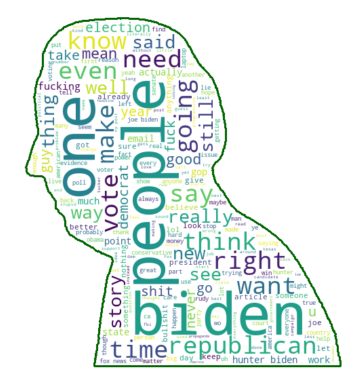

In [8]:
Biden_mask = np.array(Image.open("Illustrations/Biden_silhouette_background.png"))
wcB = WordCloud(background_color="white", 
                      mask=Biden_mask,
                      contour_width=3, 
                      repeat=True,
                      min_font_size=3,
                      contour_color='darkgreen').generate(TBC_j)
plt.figure(figsize=(10,4))
plt.imshow(wcB, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()
#wcB.to_file('WordCloud_Biden.png')

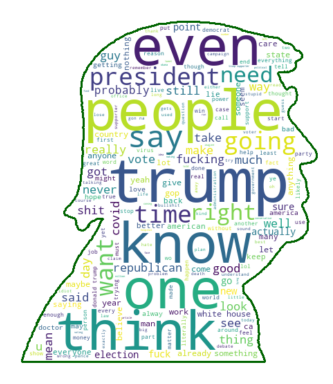

In [9]:
Trump_mask = np.array(Image.open("Illustrations/Trump_silhouette_background.png"))
wcT = WordCloud(background_color="white", 
                      mask=Trump_mask,
                      contour_width=3, 
                      repeat=True,
                      min_font_size=3,
                      contour_color='darkgreen').generate(TTC_j)
plt.figure(figsize=(10,4))
plt.imshow(wcT, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()
#wcT.to_file('WordCloud_Trump.png')

# Validation of dictionary based methods
In order for it to work, the rule-of-thumb is to have at least 10.000 tokens per document. We group them daily over the period and plot it with the desired cutoff. 

In [10]:
com_data['date'] = com_data.index
com_data['day'] = com_data['date'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d'))
documents_per_day = com_data.groupby("day").tokens.sum()

In [11]:
for i in tqdm(range(len(documents_per_day))):
    #Remove gt's and amp's
    c1 = documents_per_day[i].count('gt')
    c2 = documents_per_day[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            documents_per_day[i].remove('gt')
            documents_per_day[i].remove('amp')
        except Exception:
            pass
        
    #Remove nothings ''
    c3 = documents_per_day[i].count('')
    for j in range(0,c3):
        try:
            documents_per_day[i].remove('')
        except Exception:
            pass


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  8.91it/s]


## Log-scaled for better viewablity.

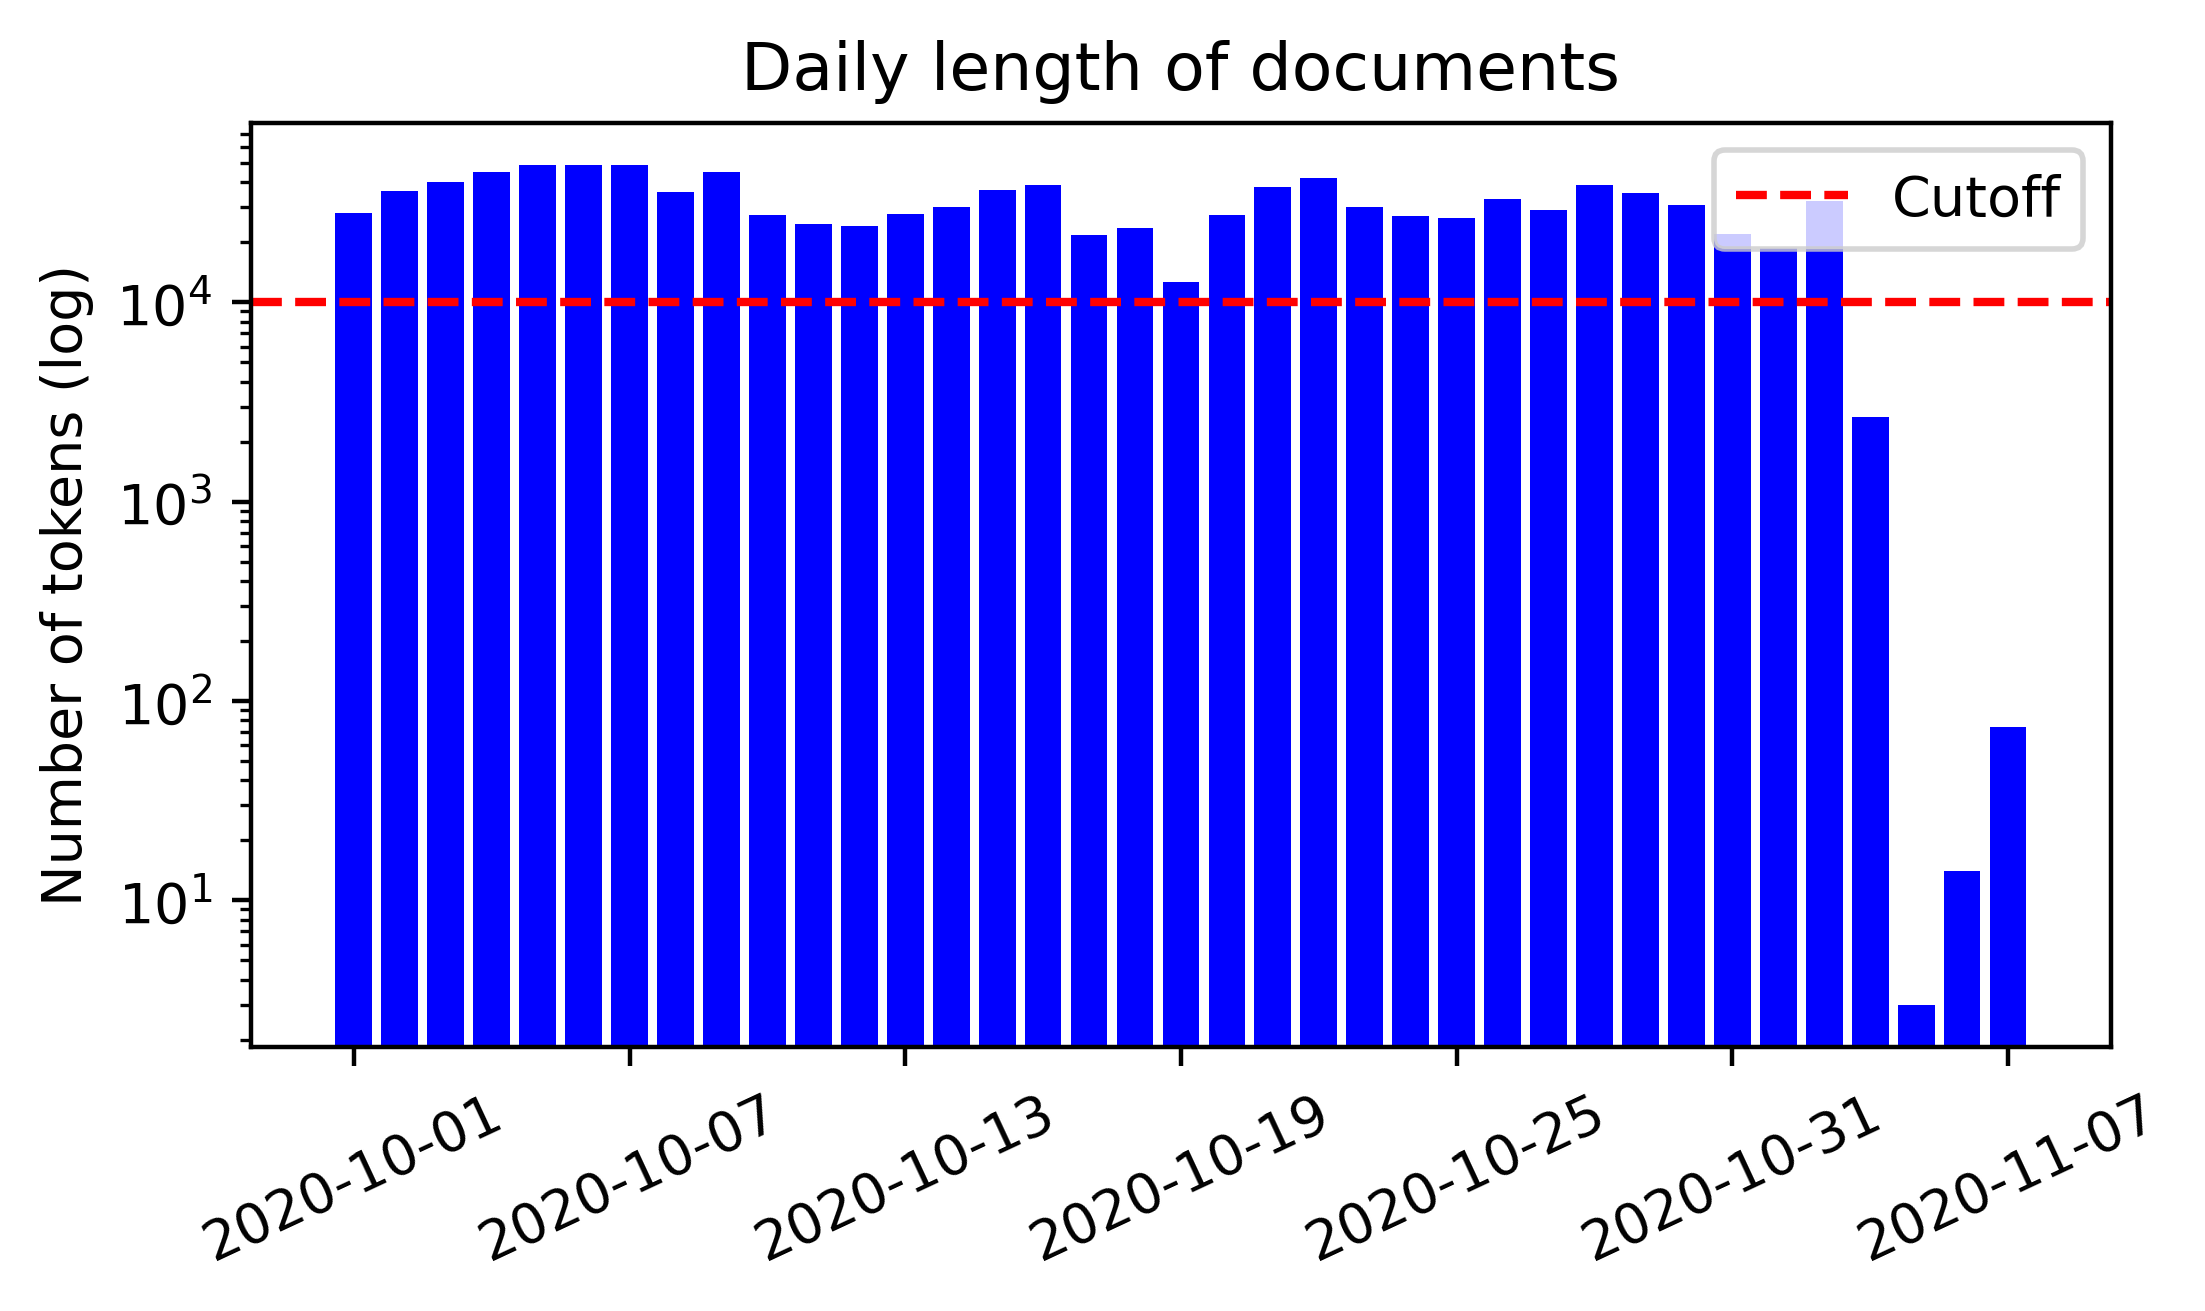

In [12]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
#plt.xticks(rotation='vertical')
ax.bar(documents_per_day.index, [len(doc) for doc in documents_per_day], color= "b")
ax.set_title("Daily length of documents")
ax.axhline(10000, color="r", linestyle="dashed", label="Cutoff")
ax.set_ylabel("Number of tokens (log)")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation = 25)
ax.set_yscale('log')
ax.legend()
plt.show()

We disregard the last 3 days in the analysis going forward, partially due to them not living up to the criteria for the methods used, but also due to the difference in comments each day for each candidate, ie. Trump has comments on 2020-11-04, while Biden does not, whereas the reverse is true for 2020-11-04.

# Happiness scores using the Hedonometer lexicon.
We load in the Hedonometer data regarding happiness scores for words and apply it in the analysis of the daily documents in the corpus.

In [13]:
labMT = pd.read_csv(r"C:\Users\JaQtae\Desktop\SocInfo2022\Hedonometer.csv", index_col="Word")
setup_mpl()

In [14]:
def hscore(tokens, p=False):
    #Iterative counter
    # If we want print p = True.
    score = 0
    freq_dict = dict(nltk.FreqDist(tokens))
    freq_norm = 0
    for word in tokens:
        # Count for word in dict
        try:
            score += labMT.loc[[word]]["Happiness Score"].values[0] * freq_dict[word]
            freq_norm += freq_dict[word]
        except:
            #Doesnt exist in labMT
            None
    hscore = score / (freq_norm+1e-06) #NaN for 0-division
    if p==True:
        return print("Happiness score: {}".format(hscore))
    else:
        return hscore

In [15]:
temp = com_data.groupby(['day', 'politician']).tokens.sum()
for i in tqdm(range(len(temp))):
    #Removal of webscrape nonsense
    c1 = temp[i].count('gt')
    c2 = temp[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            temp[i].remove('gt')
            temp[i].remove('amp')
        except Exception:
            pass

    c3 = temp[i].count('')
    for j in range(0,c3):
        try:
            temp[i].remove('')
        except Exception:
            pass

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 22.41it/s]


In [16]:
P_daily_hscore = temp.progress_apply(lambda x: hscore(x))
P_daily_hscore.index = temp.index

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [08:11<00:00,  6.82s/it]


### Here we redefine the dataset to another format that is more maleable, ie. pandas dataframes with the indexing wanted.

In [18]:
B_hscores = []
T_hscores = []
for q in range(len(P_daily_hscore)):
    if P_daily_hscore.index[q].count('Biden') == 1:
        B_hscores.append(P_daily_hscore[q])
    elif P_daily_hscore.index[q].count('Trump') == 1:
        T_hscores.append(P_daily_hscore[q])
    else:
        pass

In [19]:
#Sanity check
len(B_hscores) == len(T_hscores)

True

In [20]:
df_B = pd.DataFrame()
df_T = pd.DataFrame()
df_B['B_hscore'] = B_hscores
df_T['T_hscore'] = T_hscores

In [22]:
catcher = []
tester = []
for k in range(len(P_daily_hscore)):
    if P_daily_hscore.index[k].count('Biden') == 1:
        catcher.append(P_daily_hscore.index[k][0])
    elif P_daily_hscore.index[k].count('Trump') == 1:
        tester.append(P_daily_hscore.index[k][0])

### The values are dropped in correspondence with the previous comments regarding cut-off of the tail end of the dictionary based methodology criterium.

In [23]:
del catcher[-2:]
del tester[-2:]
df_B.drop(df_B.tail(2).index,inplace=True)
df_T.drop(df_T.tail(2).index,inplace=True)
df_B.index = catcher

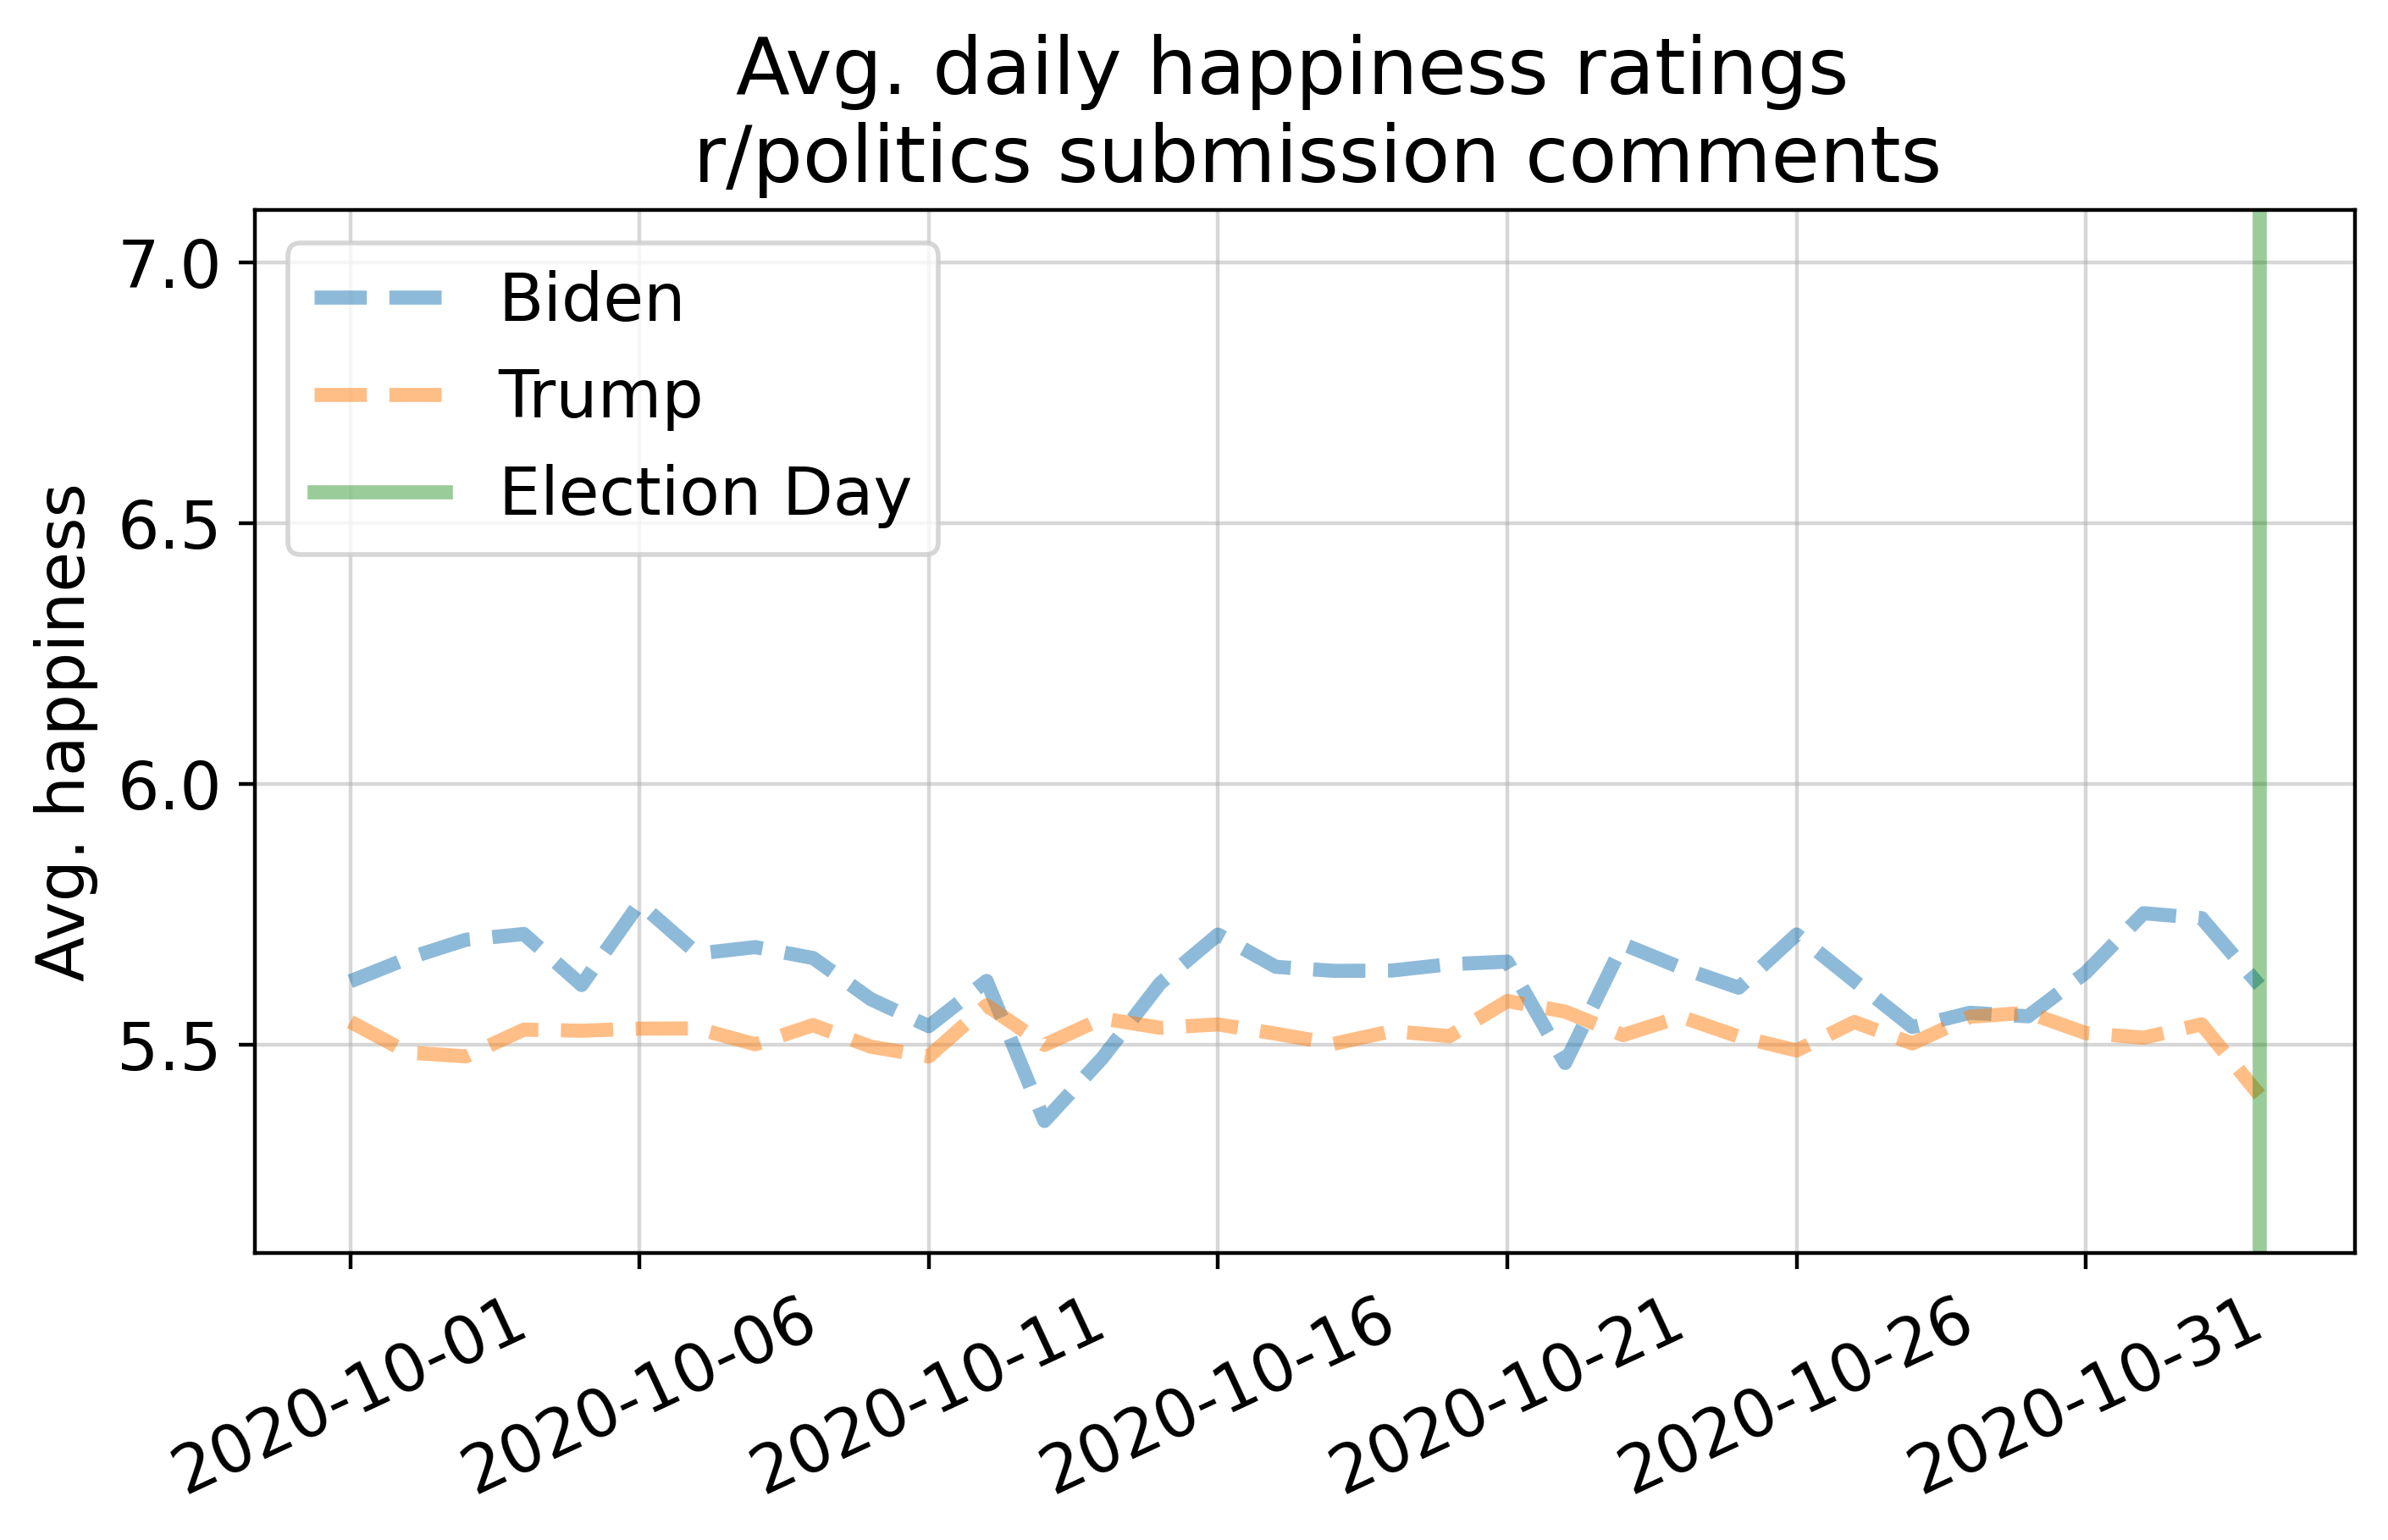

In [24]:
fig, ax = plt.subplots(figsize=(8,4), dpi=400)
ax.plot(df_B.index, df_B, ls = "--", alpha = 0.5, label='Biden')
ax.plot(df_T.index, df_T, ls = "--", alpha = 0.5, label='Trump')
plt.axvline(x=df_B.index[-1], color='green', alpha = 0.4, label='Election Day')
ax.set_title("Avg. daily happiness ratings \n r/politics submission comments")
ax.set_ylabel("Avg. happiness")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
plt.xticks(rotation = 25)
plt.ylim(5.1,7.1)
plt.grid(alpha=0.5)
ax.legend()
plt.show()

# Word Shifterator plots
We chose the election day as the day to remark upon, and compare it to the whole previous part of the dataset to investigate changes of sentiment over time. This amounts to a total of 33 days contained in the reference dictionary.

In [25]:
election_day = P_daily_hscore.index[-5][0]
print('Election day is: {}'.format(election_day))
d_T = datetime.strptime(P_daily_hscore.index[-5][0], '%Y-%m-%d')
d_m = (d_T- dt.timedelta(days=33)).strftime('%Y-%m-%d') #string format

Election day is: 2020-11-03


In [26]:
l = documents_per_day.loc[election_day]
l_ref = np.concatenate(documents_per_day[(documents_per_day.index < election_day) & \
                                (documents_per_day.index > d_m)].values)

In [27]:
p_l = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_lref = dict([(item[0], item[1]/len(l)) for item in Counter(l_ref).items()])
sorted(p_lref.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 7.258979206049149),
 ('like', 3.2827977315689982),
 ('people', 3.255954631379962),
 ('would', 2.942533081285444),
 ('get', 2.0862003780718337),
 ('one', 2.0139886578449904),
 ('even', 1.662381852551985),
 ('going', 1.6544423440453686),
 ('think', 1.6351606805293006),
 ('know', 1.5497164461247637)]

In [28]:
sorted(p_l.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 0.0166351606805293),
 ('would', 0.010964083175803403),
 ('like', 0.00945179584120983),
 ('people', 0.008695652173913044),
 ('prison', 0.006427221172022685),
 ('right', 0.005671077504725898),
 ('go', 0.005671077504725898),
 ('vote', 0.005671077504725898),
 ('think', 0.004914933837429111),
 ('get', 0.004914933837429111)]

So the main topic surrounds trump and people, however on the day of election voting seems to be more significant, understandably so.

In [32]:
# [(token, diff(p_l, p_lref))]
# Do it for every word in the union of sets of words for corpora
d_p = dict([(token, p_l.get(token, 0) -  p_lref.get(token, 0)) \
               for token in set(p_l.keys()).union(set(p_lref.keys()))])

In [30]:
labMT_dict = pd.Series(labMT["Happiness Score"].values, index=labMT.index).to_dict()
prep_hscore =  dict([(token, labMT_dict.get(token, np.nan)-5) for token in set(p_l.keys()).union(set(p_lref.keys()))])

d_phi = dict([(token, prep_hscore[token]*d_p[token]) for token in set(p_l.keys()).union(set(p_lref.keys()))\
                    if not np.isnan(prep_hscore[token])]) #Do it for everything that isn't NaN
# Absolute value sorting top 10
sorted(d_phi.items(), key = lambda x: np.abs(x[1]), reverse=True)[:10]

[('like', -7.26682797731569),
 ('people', -3.7668204158790175),
 ('covid', 3.1454820415879015),
 ('shit', 2.4234404536862004),
 ('good', -2.278185255198488),
 ('trump', -2.1727032136105846),
 ('right', -2.033149338374291),
 ('think', -1.9562948960302462),
 ('get', -1.914782608695652),
 ('well', -1.8464120982986765)]

The $\delta\phi$ value identifies the extent a given set of words contribute to the difference in scores and how they do it. Either a word is used more often in one text over the other and its influence, positive or negative, is weighted in the relative frequency. This matches very well with the Word Cloud representation of the texts.

C:\Users\JaQtae\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


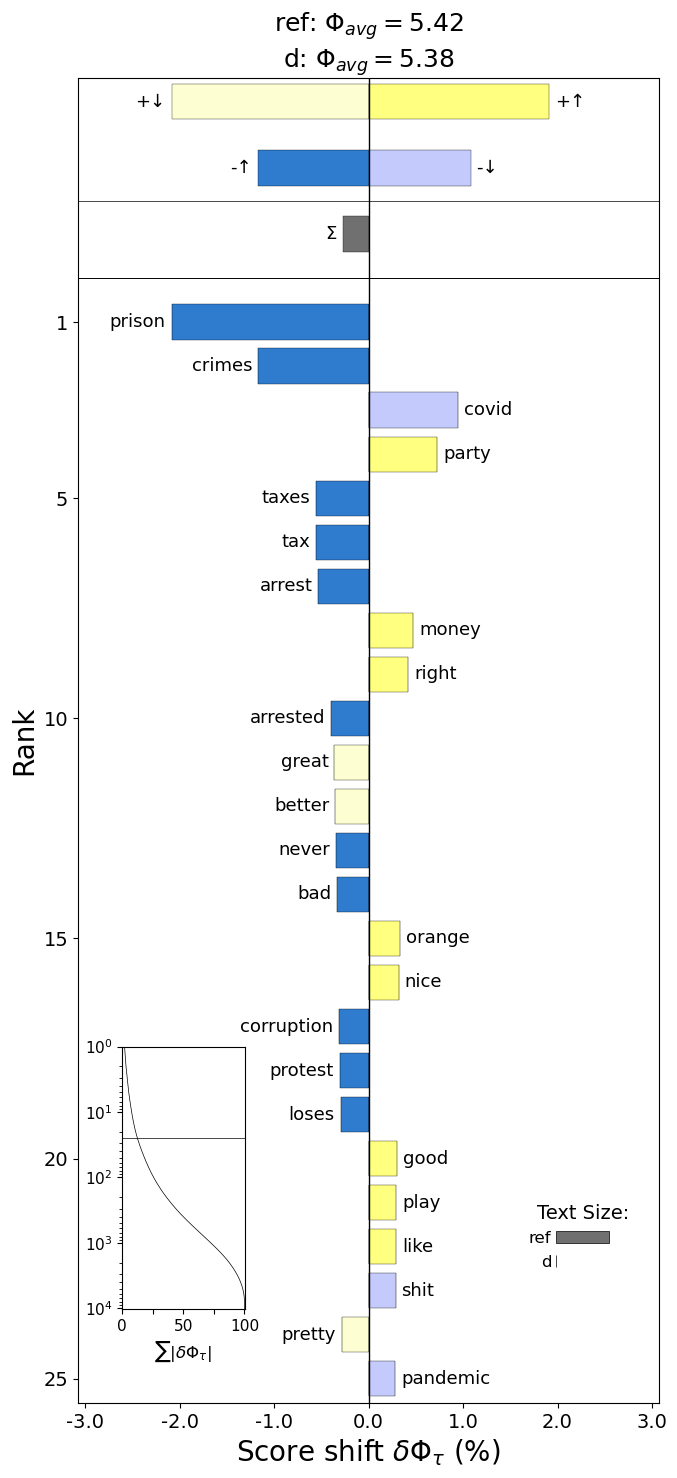

<AxesSubplot:title={'center':'ref: $\\Phi_{avg}=$5.42\nd: $\\Phi_{avg}=$5.38'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [37]:
import shifterator as sft
senti_shift = sft.WeightedAvgShift(type2freq_1 = p_lref,
                                     type2freq_2 = p_l,
                                     type2score_1 = labMT_dict,
                                     reference_value = 5)
senti_shift.get_shift_graph(detailed = True,
                            system_names = ['ref', 'd'],
                            top_n=25)
                            #filename='shifteratorGraph.svg')

Gone down on by 0.04 in comparison (neglible imo)